In [ ]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
from matplotlib.patches import Rectangle, Circle # for visualizing the robot, landmarks

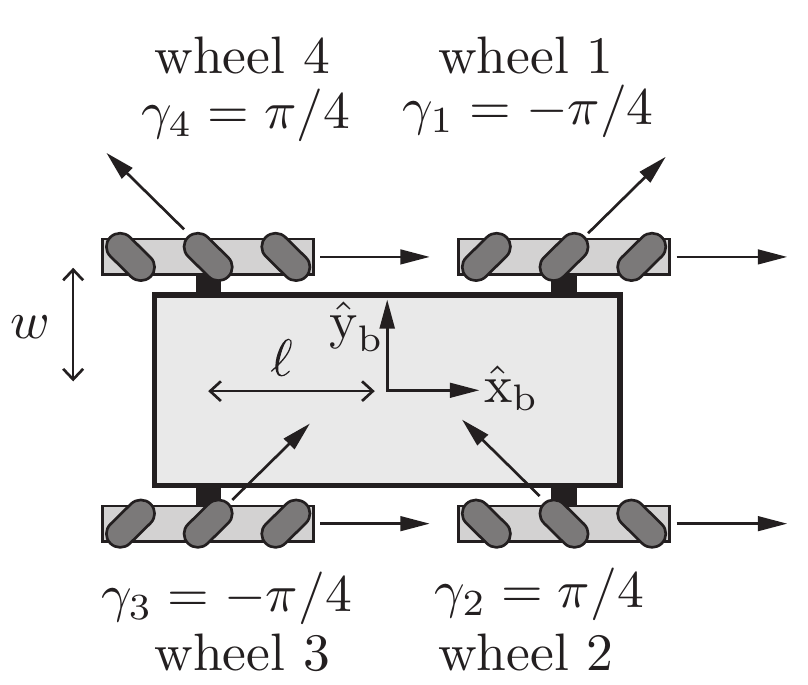

In [ ]:
# position of wheels in body frame
w = 0.2
l = 0.5
positions = [(l, w), (l, -w), (-l, -w), (-l, w)]

# angles of "free-sliding"
gammas = [-np.pi/4., np.pi/4., -np.pi/4., np.pi/4.]
# rotation of direction!
betas = [0., 0., 0., 0.]

wheel_radius = 0.1

In [ ]:
def compute_H(theta, positions, gammas, betas, wheel_radius):
    m = len(positions) # number of wheels
    h_all = np.zeros((m, 3))
    for i in range(m):
        prefix = 1. / (wheel_radius * np.cos(gammas[i]))
        x_i, y_i = positions[i]
        s1 = np.sin(betas[i] + gammas[i])
        c1 = np.cos(betas[i] + gammas[i])
        s2 = np.sin(betas[i] + gammas[i] + theta)
        c2 = np.cos(betas[i] + gammas[i] + theta)
        h_all[i, :] = prefix * np.array([[x_i * s1 - y_i * c1, c2, s2]])
    return h_all

In [ ]:
def integrate(p, Vb, dt):
    # Rotate Vb to Vw
    R = np.array([[1., 0., 0.], [0., np.cos(p[0, 0]), -np.sin(p[0, 0])], [0., np.sin(p[0, 0]), np.cos(p[0, 0])]])
    if abs(Vb[0, 0]) < 1e-6:
        return p + R @ Vb * dt
    else:
        omega = Vb[0, 0]
        vx = Vb[1, 0]
        vy = Vb[2, 0]
        dp = np.array([[omega], [(vx*np.sin(omega) + vy*(np.cos(omega) - 1.)) / omega], [(vy*np.sin(omega) + vx*(1. - np.cos(omega))) / omega]])
        return p + R @ dp * dt

In [ ]:
# A few helpers
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

In [ ]:
# Map
# We have several landmarks!
landmarks = [(4., 4.), (4., 0.), (4., -4.), (0., -4.), (-4., -4.), (-4., 0.), (-4., 4.), (0., 4.)]
colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'black', 'purple', 'orange']

In [ ]:
# We assume that the robot is equiped with a lidar
#   the lidar has a width centered in the heading of the robot
#   the lidar can also have some noise

# Let's create a function that given the pose of the robot, return the hits of the lidar rays
def lidar(x, landmarks, width = 3. * np.pi / 4., noise = 1e-3):
    detects = []

    theta = x[0, 0] # heading of the robot
    for k in range(len(landmarks)):
        lx = landmarks[k][0] + np.random.randn() * noise
        ly = landmarks[k][1] + np.random.randn() * noise
        xx = lx - x[1, 0]
        yy = ly - x[2, 0]
        rel = np.arctan2(yy, xx)
        rel = angle_dist(rel, theta)
        if rel >= -width/2. and rel <= width/2.:
            r = np.sqrt(xx**2 + yy**2)
            detects += [(r, rel, k + 1)] # (distance, angle difference, identity)
    return detects

In [ ]:
# Motion model and derivative
def motion_model(x, u, dt = 0.1):
    out = x
    out[:3, :] += u # only the robot state is affected
    return out

def motion_model_deriv(x, u, dt = 0.1):
    return np.eye(x.shape[0])

# Helper function: get action u from actual odometry poses
def u_from_poses(xn, xp, dt = 0.1):
    dx = xn[1, 0] - xp[1, 0]
    dy = xn[2, 0] - xp[2, 0]
    dtheta = angle_dist(xn[0, 0], xp[0, 0])
    return np.array([[dtheta, dx, dy]]).T

In [ ]:
# Observation model and derivative
def observation_model(x, landmark_pose):
    dx = landmark_pose[0, 0] - x[1, 0]
    dy = landmark_pose[1, 0] - x[2, 0]
    rel = np.arctan2(dy, dx)
    rel = angle_dist(rel, x[0, 0])
    return np.array([[np.sqrt(dx**2+dy**2), rel]]).T

def observation_model_deriv(x, landmark_pose):
    dx = landmark_pose[0, 0] - x[1, 0]
    dy = landmark_pose[1, 0] - x[2, 0]
    dist_sq = dx**2+dy**2
    dist = np.sqrt(dist_sq)

    jac = np.zeros((2, 5))
    # rel wrt θ
    jac[1, 0] = -1.
    # dist wrt x
    jac[0, 1] = -dx / dist
    # dist wrt y
    jac[0, 2] = -dy / dist
    # dist wrt lx
    jac[0, 3] = dx / dist
    # dist wrt ly
    jac[0, 4] = dy / dist
    # rel wrt x
    jac[1, 1] = dy / dist_sq
    # rel wrt y
    jac[1, 2] = -dx / dist_sq
    # rel wrt lx
    jac[1, 3] = -dy / dist_sq
    # rel wrt ly
    jac[1, 4] = dx / dist_sq

    return jac

In [ ]:
# Helpers
def Fxj(k):
    l_idx = 3 + k * 2
    F = np.zeros((5, 3 + 2 * len(landmarks)))
    F[:3, :3] = np.eye(3)
    F[3:, l_idx : l_idx + 2] = np.eye(2)

    return F

In [ ]:
UNSEEN = 1000000.

# EKF SLAM Update
def ekf_slam_step(mu, sig, u, z, R, Q):
    mu_bar = motion_model(mu, u)
    G = motion_model_deriv(mu, u)
    R_all = np.zeros(sig.shape) # zeros everywhere
    R_all[:3, :3] = R # except for the robot motion uncertainty
    sig_bar = G @ sig @ G.T + R_all
    for k in range(len(z)):
        r_i = z[k][0]
        phi_i = z[k][1]
        l_idx = 3 + (z[k][2] - 1) * 2
        if sig_bar[l_idx, l_idx] == UNSEEN: # first time we see this landmark!
            xx = mu_bar[1, 0]
            yy = mu_bar[2, 0]
            theta = mu_bar[0, 0]
            mu_bar[l_idx, 0] = xx + r_i * np.cos(theta + phi_i)
            mu_bar[l_idx + 1, 0] = yy + r_i * np.sin(theta + phi_i)
            sig_bar[l_idx : l_idx + 2, l_idx : l_idx + 2] = Q
        z_i = observation_model(mu_bar[:3, :], mu_bar[l_idx : l_idx+2, :])
        F = Fxj((z[k][2] - 1))
        dfZ = observation_model_deriv(mu_bar[:3, :], mu_bar[l_idx : l_idx+2, :]) @ F
        K = sig_bar @ dfZ.T @ np.linalg.inv(dfZ @ sig_bar @ dfZ.T + Q)
        zk = np.array([[r_i, phi_i]]).T
        mu_bar = mu_bar + K @ (zk - z_i)
        mu_bar[0, 0] = angle_dist(mu_bar[0, 0], 0.)
        sig_bar = (np.eye(*sig.shape) - K @ dfZ) @ sig_bar
    return mu_bar, sig_bar

In [ ]:
R = np.eye(3) * 0.1 # noise for movement!
Q = np.eye(2) * 0.01 # noise for observation!

In [ ]:
# Let's do a small simulation
p = np.zeros((3, 1)) # position and theta of the base (θ, x, y)
p[1, 0] = -2.
p[2, 0] = 2.

# target pose
targets = []
targets += [np.array([[-np.pi / 2., 2., -2.]]).T]
targets += [np.array([[0., -3., -3.]]).T]
targets += [np.array([[-np.pi, 3., 3.]]).T]
curr_target = 0

# timestep
dt = 0.1

# For odometry
H0 = compute_H(0., positions, gammas, betas, wheel_radius)
H0inv = np.linalg.pinv(H0)
odom_poses = [np.copy(p)]
odom_p = np.copy(p)

# EKF SLAM
x = np.zeros((3 + 2 * len(landmarks), 1))
x[:3, :] = np.copy(p)
S_init = np.eye(3 + 2 * len(landmarks)) * 0.001 # We start with a small uncertainty!
S_init[3:, 3:] = np.eye(2 * len(landmarks)) * UNSEEN
estimation = [(np.copy(x), S_init)]

all_poses = [np.copy(p)]
max_steps = 20000
step = 0
while curr_target < len(targets) and np.linalg.norm(targets[curr_target] - p) > 1e-3: # while we haven't reached the target
    diff = targets[curr_target] - p # desired velocity (aka reach at the target at one step!)
    H = compute_H(p[0, 0], positions, gammas, betas, wheel_radius) # get current H
    u = H @ diff # transform desired velocity to wheel commands
    max_u = 0.5
    u = np.maximum(-max_u, np.minimum(max_u, u)) # we cannot do arbitrary wheel commands
    # Forward simulation using the inverse of H matrix + Euler integration
    u_bad = np.copy(u) * np.random.uniform(low=0.5, high=1., size=(4,1))
    # u_bad[2, 0] = 0.8 * u[2, 0] # one wheel is spinning more!
    v = np.linalg.pinv(H) @ u_bad
    p = p + v * dt

    # Compute Odometry!
    Vb = H0inv @ u
    odom_p = integrate(odom_p, Vb, dt)
    # Just for visuals
    all_poses += [p]
    odom_poses += [odom_p]
    # EKF SLAM update
    mu, sig = estimation[-1]
    u_slam = u_from_poses(odom_poses[-1], odom_poses[-2], dt) # compute odometry controls

    z = lidar(p, landmarks, noise=1e-2)
    estimation.append(ekf_slam_step(mu, sig, u_slam, z, R, Q))

    step += 1
    if step >= max_steps:
        break
    if np.linalg.norm(targets[curr_target] - p) <= 1e-3:
        curr_target += 1
        curr_target = curr_target % len(targets)

np.set_printoptions(precision = 3, suppress = True, linewidth = 200)
print(estimation[-1][0][:3, :].T)
# print(estimation[-1][1])
print(p.T)
print(odom_p.T)

In [ ]:
%matplotlib
import matplotlib.pyplot as plt # Plotting

plt.ion()

# Visualize the trajectory
fig = plt.figure()
# for stopping simulation with the esc key.
fig.canvas.mpl_connect('key_release_event', lambda event: [exit(0) if event.key == 'escape' else None])

ax = fig.add_subplot(111)

def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


for i in range(0, len(all_poses), 40):
    plt.cla()
    # Set the limits for the environment
    plt.xlim(-6, 6);
    plt.ylim(-6, 6);

    # Plot ground truth landmarks
    for k in range(len(landmarks)):
        rect = Circle(landmarks[k], 0.5, edgecolor = colors[k], fill=False)
        # add rectangle to plot
        ax.add_patch(rect)
        ax.annotate(str(k+1), xy=landmarks[k], fontsize=20, ha="center", va="center")

    # Plot actual pose
    p = np.copy(all_poses[i])
    # compute positions
    bpb = np.array([[-l, -w]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]

    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 2*l, 2*w, edgecolor = 'black', fill=False, angle=p[0, 0] * 180. / np.pi)
    # add rectangle to plot
    ax.add_patch(rect)

    # Plot odometry
    p = np.copy(odom_poses[i])
    # compute positions
    bpb = np.array([[-l, -w]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]

    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 2*l, 2*w, edgecolor = 'red', fill=False, angle=p[0, 0] * 180. / np.pi)
    # add rectangle to plot
    ax.add_patch(rect)

    # Plot EKF SLAM estimation
    p = np.copy(estimation[i][0][:3, :])
    # compute positions
    bpb = np.array([[-l, -w]]).T
    bpw = rot(p[0, 0]) @ bpb + p[1:, :]

    rect = Rectangle((bpw[0, 0], bpw[1, 0]), 2*l, 2*w, edgecolor = 'blue', fill=False, angle=p[0, 0] * 180. / np.pi)
    # add rectangle to plot
    ax.add_patch(rect)

    # Plot estimated landmarks
    f_est = estimation[i][0]
    sig_bar = estimation[i][1]
    for k in range(len(landmarks)):
        idx = 3 + k * 2
        x_pos = f_est[idx, 0]
        y_pos = f_est[idx+1, 0]
        if sig_bar[idx, idx] == UNSEEN: # ignore un-detected landmarks
            y_pos = -5.5
            x_pos = -6. + k * 1.5
        rect = Circle((x_pos, y_pos), 0.5, edgecolor = 'cyan', fill=False)
        # add rectangle to plot
        ax.add_patch(rect)
        ax.annotate(str(k+1), xy=(x_pos, y_pos), fontsize=20, ha="center", va="center")

    plt.pause(0.001)